<a href="https://colab.research.google.com/github/werlang/emolearn-ml-model/blob/main/daisee_eng_merge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence, plot_model, to_categorical
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import TimeDistributed, GRU, LSTM, Dropout, Conv1D, Conv2D, Conv3D, ConvLSTM2D, BatchNormalization, MaxPooling1D, MaxPooling2D, MaxPooling3D, GlobalAveragePooling2D, Flatten, Dense, Input, Add, Activation, AveragePooling3D, AveragePooling2D, ZeroPadding3D, Bidirectional, Concatenate
from tensorflow.keras.optimizers import Adam, SGD, Nadam
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, Callback, ModelCheckpoint
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
import pandas as pd
import numpy as np
import os, cv2
import datetime
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import math
from IPython.display import Image, display
from numba import cuda
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler 
import functools

# from imblearn.over_sampling import SMOTE
# sm = SMOTE(sampling_strategy=0.6666)
# X, y = sm.fit_resample(X, y)


drive_save_path = 'drive/My Drive/1NOSYNC/DT/checkpoint'
labels_path = 'labels'
features_path = 'features'
ident_name = 'daisee-eng-merge'
dir_name = '2021-6-22-12-47-14-daisee-eng-merge'
batch_size = 64
time_frames = 20
interval = 2
stride = 1
fold_step = 1
n_folds = 5

epoch = 0

def restart():
    cuda.select_device(0)
    cuda.close()


def start_colab():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    !pip install Keras-Applications
    # !pip install git+https://github.com/rcmalli/keras-vggface.git
    !pip install keras-tcn


def extract_data():
    !mkdir features

    print("COPYING TRAIN SET...")
    !unzip -n -q "drive/My Drive/1NOSYNC/DT/daisee_aligned/Train.zip" -d features 
    print("COPYING VALIDATION SET...")
    !unzip -n -q "drive/My Drive/1NOSYNC/DT/daisee_aligned/Validation.zip" -d features 
    print("COPYING TEST SET...")
    !unzip -n -q "drive/My Drive/1NOSYNC/DT/daisee_aligned/Test.zip" -d features 
    print("COPYING OPENFACE FEATURES...")
    !unzip -n -q "drive/My Drive/Doutorado/Implementação/daisee_openface.zip" -d of_features
    print("COPYING LABELS...")
    !cp -r "drive/My Drive/Doutorado/Implementação/labels" ./

    print("DONE")


def create_folds():
    num_classes = 2
    print("CREATING FOLDS...")
    subs = {}

    Y = []
    clips = []
    # just concatenate all splits
    for split in ["Train", "Validation"]:
        csv_path = "{}/{}Labels.csv".format(labels_path, split)
        csv = pd.read_csv(csv_path)
        C = np.array(csv['ClipID'])
        Yt = np.array(csv.iloc[:,1:])
        if len(Y) == 0:
            clips = C
            Y = Yt
        else:
            Y = np.concatenate((Y, Yt), axis=0)
            clips = np.concatenate((clips, C), axis=0)
    Y = to_categorical(np.array(Y[:,1]) // (4 // num_classes), num_classes)
    

    for i in range(len(clips)):
        file_name = clips[i].split(".")[0]
        subject = int(file_name[:6])
        if not subject in subs:
            subs[subject] = [0 for x in range(num_classes)]
        subs[subject] = np.add(subs[subject], Y[i])

    # total = np.sum(Y, axis=0)
    # print(total, total / len(Y))
    # print(subs)

    folds = []
    fold_names = []
    for i in subs:
        if len(folds) < n_folds:
            folds.append(subs[i])
            fold_names.append([i])
        else:
            summed = np.sum(folds, axis=1)
            index = list(summed).index(min(summed))
            folds[index] = np.add(folds[index], subs[i])
            fold_names[index].append(i)

    # print(folds)
    # print(fold_names)
    # print(np.sum(folds, axis=1))

    # print("GETTING FOLDS DATA...")
    # build frames array
    videos, labels, opface = [], [], []
    for i in range(len(fold_names)):
        videos.append([])
        opface.append([])
        labels.append([])

    fps = 15
    skip = int(round(interval * fps / time_frames, 0))

    split_start = []
    csv_path = "{}/TrainLabels.csv".format(labels_path)
    csv = pd.read_csv(csv_path)
    split_start.append(len(csv))
    csv_path = "{}/ValidationLabels.csv".format(labels_path)
    csv = pd.read_csv(csv_path)
    split_start.append(split_start[0] + len(csv))

    for Yi in range(len(clips)):
        file_name = clips[Yi].split(".")[0]
        subject = file_name[:6]

        for f in range(n_folds):
            if int(subject) in fold_names[f]:
                # print("{}/{}".format(split, subject))
                split = 'Train' if Yi < split_start[0] else 'Validation'
                # get aligned faces file names into files array
                dir_path = "{}/{}/{}/{}_aligned".format(features_path, split, subject, file_name)
                of_path = "of_{}/{}/{}/{}.csv".format(features_path, split, subject, file_name)
                files, filesof = [], []

                if os.path.isfile(of_path):
                    csv_of = pd.read_csv(of_path)
                    rows = csv_of[[' gaze_0_x',' gaze_0_y',' gaze_0_z',' gaze_1_x',' gaze_1_y',' gaze_1_z',' gaze_angle_x',' gaze_angle_y',' pose_Tx',' pose_Ty',' pose_Tz',' pose_Rx',' pose_Ry',' pose_Rz',' AU01_r',' AU02_r',' AU04_r',' AU05_r',' AU06_r',' AU07_r',' AU09_r',' AU10_r',' AU12_r',' AU14_r',' AU15_r',' AU17_r',' AU20_r',' AU23_r',' AU25_r',' AU26_r',' AU45_r',' AU01_c',' AU02_c',' AU04_c',' AU05_c',' AU06_c',' AU07_c',' AU09_c',' AU10_c',' AU12_c',' AU14_c',' AU15_c',' AU17_c',' AU20_c',' AU23_c',' AU25_c',' AU26_c',' AU28_c',' AU45_c']]
                    # rows = csv_of.iloc[:,5:]
                    min_max_scaler = MinMaxScaler()
                    rows = min_max_scaler.fit_transform(rows)
                
                # there are only 150 files in each folder
                for i in range(1,350):
                    image_path = "{}/frame_det_00_000{:03d}.jpg".format(dir_path, i)
                    if os.path.isfile(image_path) and os.path.isfile(of_path):
                        files.append(image_path)
                        filesof.append(rows[i-1])

                # append only the parts relative to the video section
                last = (len(files) - time_frames*skip) // skip
                for i in range(0, last + 1, np.max([1, int(stride * time_frames)])):
                    temp, tpof = [], []
                    for j in range(i*skip, (i+time_frames)*skip, skip):
                        temp.append(files[j])
                        tpof.append(filesof[j])
                    videos[f].append(temp)
                    opface[f].append(tpof)
                    labels[f].append(Y[Yi])

    return videos, opface, labels


def save_folds(folds_data):
    videos, opface, labels = folds_data

    !mkdir folds

    first_only = True

    # ros = RandomOverSampler(random_state=42, sampling_strategy={0: 4000, 1: 31870})
    # rus = RandomUnderSampler(random_state=42, sampling_strategy={0: 4000, 1: 10000})
    for i in range(n_folds):
        print("SAVING FOLD {}...".format(i+1))
        train_X = videos.copy()
        train_XO = opface.copy()
        train_Y = labels.copy()

        val_X = train_X.pop(i)
        val_XO = train_XO.pop(i)
        val_Y = train_Y.pop(i)

        train_X = np.concatenate(train_X)
        train_XO = np.concatenate(train_XO)
        train_Y = np.concatenate(train_Y)

        # create index array for resample
        I = np.array([x for x in range(len(train_X))]).reshape(-1,1)

        # I, train_Y = ros.fit_resample(I, train_Y)
        # I, train_Y = rus.fit_resample(I, train_Y)
        # needed only when 2 classes
        # train_Y = to_categorical(train_Y, 2)

        # copy resampled elements from original arrays according to resampling indexes
        ntx, ntxo = [], []
        for x in I:
            ntx.append(train_X[x[0]])
            ntxo.append(train_XO[x[0]])
        train_X = ntx
        train_XO = ntxo

        # save folds to file
        train_Y = np.array(train_Y)
        np.save("folds/fold_{}_train_Y.npy".format(i), train_Y)
        
        train_X = np.array(train_X)
        np.save("folds/fold_{}_train_XV.npy".format(i), train_X)

        train_XO = np.array(train_XO)
        np.save("folds/fold_{}_train_XO.npy".format(i), train_XO)

        val_Y = np.array(val_Y)
        np.save("folds/fold_{}_validation_Y.npy".format(i), val_Y)
        
        val_X = np.array(val_X)
        np.save("folds/fold_{}_validation_XV.npy".format(i), val_X)

        val_XO = np.array(val_XO)
        np.save("folds/fold_{}_validation_XO.npy".format(i), val_XO)

        if first_only:
            break


def getTest():
    num_classes = 2
    print("SAVING TEST DATA...")
    csv_path = "{}/TestLabels.csv".format(labels_path)
    csv = pd.read_csv(csv_path)

    clips = np.array(csv['ClipID'])
    Y = to_categorical(np.array(csv['Engagement']) // (4 // num_classes), num_classes)

    fps = 15
    skip = int(round(interval * fps / time_frames, 0))

    videos, opface, labels = [], [], []

    for Yi in range(len(clips)):
        file_name = clips[Yi].split(".")[0]
        subject = file_name[:6]

        dir_path = "{}/Test/{}/{}_aligned".format(features_path, subject, file_name)
        of_path = "of_{}/Test/{}/{}.csv".format(features_path, subject, file_name)

        files, filesof = [], []

        if os.path.isfile(of_path):
            csv_of = pd.read_csv(of_path)
            rows = csv_of[[' gaze_0_x',' gaze_0_y',' gaze_0_z',' gaze_1_x',' gaze_1_y',' gaze_1_z',' gaze_angle_x',' gaze_angle_y',' pose_Tx',' pose_Ty',' pose_Tz',' pose_Rx',' pose_Ry',' pose_Rz',' AU01_r',' AU02_r',' AU04_r',' AU05_r',' AU06_r',' AU07_r',' AU09_r',' AU10_r',' AU12_r',' AU14_r',' AU15_r',' AU17_r',' AU20_r',' AU23_r',' AU25_r',' AU26_r',' AU45_r',' AU01_c',' AU02_c',' AU04_c',' AU05_c',' AU06_c',' AU07_c',' AU09_c',' AU10_c',' AU12_c',' AU14_c',' AU15_c',' AU17_c',' AU20_c',' AU23_c',' AU25_c',' AU26_c',' AU28_c',' AU45_c']]
            # rows = csv_of.iloc[:,5:]
            min_max_scaler = MinMaxScaler()
            rows = min_max_scaler.fit_transform(rows)
        
        for i in range(1,350):
            image_path = "{}/frame_det_00_000{:03d}.jpg".format(dir_path, i)
            if os.path.isfile(image_path) and os.path.isfile(of_path):
                files.append(image_path)
                filesof.append(rows[i-1])

        # append only the parts relative to the video section
        last = (len(files) - time_frames*skip) // skip
        for i in range(0, last + 1, np.max([1, int(stride * time_frames)])):
            temp, tpof = [], []
            for j in range(i*skip, (i+time_frames)*skip, skip):
                temp.append(files[j])
                tpof.append(filesof[j])
            videos.append(temp)
            opface.append(tpof)
            labels.append(Y[Yi])

    np.save("folds/test_XV.npy", videos)
    np.save("folds/test_XO.npy", opface)
    np.save("folds/test_Y.npy", labels)


class Generator_V(Sequence):
    def __init__(self, gen_split, batch_size, frames):
        print("BUILDING GENERATOR...")
        self.batch_size = batch_size 
        self.labels, self.videos, = [], []

        file_prefix = "" if gen_split == "Test" else "fold_{}_".format(fold_step-1)
        self.videos = np.load("folds/{}{}_XV.npy".format(file_prefix, gen_split.lower()))
        self.opface = np.load("folds/{}{}_XO.npy".format(file_prefix, gen_split.lower()))
        self.labels = np.load("folds/{}{}_Y.npy".format(file_prefix, gen_split.lower()))

        # self.videos, self.labels = shuffle(self.videos, self.labels, random_state=0)
        print("Done")


    def __len__(self):
        return int(np.ceil(len(self.videos) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_xv = self.videos[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_xo = self.opface[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]

        videos, opface = [], []
        for video in batch_xv:
            images = []
            for name in video:
                img = cv2.imread(name)
                images.append(img/255)
            videos.append(np.array(images))

        # videos = np.expand_dims(videos, axis=4)
        videos = np.array(videos)
        opface = np.array(batch_xo)
        label = np.array(batch_y)

        # regressor
        # label = np.array(batch_y).argmax(axis=1) / 3

        return [videos, opface], label
        # return videos, label
        # return opface, label


def build_model(epoch=0, print_model=False):
    from tcn import TCN, tcn_full_summary

    img_size = 224
    of_features = 49

    def model_convlstm(input):
        filters = 256

        x = ConvLSTM2D(filters, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(5e-4), recurrent_regularizer=l2(1e-6), return_sequences=True)(input)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = ConvLSTM2D(filters, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(5e-4), recurrent_regularizer=l2(1e-6), return_sequences=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = MaxPooling2D(pool_size=3, strides=2, padding='valid')(x)
        x = Flatten()(x)

        return x

    def model_openface(input):
        filters = 1024

        x = TCN(filters)(input)
        
        return x

    def model_inception(input):
        inception = tf.keras.applications.InceptionResNetV2(
            input_shape = (img_size, img_size, 3),
            weights = 'imagenet',
            include_top = False
        )

        for layer in inception.layers:
            layer.trainable = False

        x = TimeDistributed(inception)(input)

        return x

    print("Building model...")
    ########### IF BUILT, MUST DEFINE A NAME TO APPEND TO DIRECTORY NAME ###############
    global ident_name

    ########### IF LOADED, MUST DEFINE DIR NAME AND STARTING EPOCH ############
    global dir_name

    if not epoch:
        input_v = Input(shape=(time_frames, img_size, img_size, 3))
        input_o = Input(shape=(time_frames, of_features))

        m1 = model_inception(input_v)
        m2 = model_convlstm(m1)
        m3 = model_openface(input_o)

        # joint model
        x = Concatenate()([m2, m3])
        
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.8)(x)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.8)(x)
        x = Dense(2, activation='softmax')(x)

        model = Model([input_v, input_o], x)
        # model = Model(input_v, x)

        model.compile(
            # loss='mse',
            loss='categorical_crossentropy',
            optimizer = SGD(learning_rate=0.0001, momentum=0.9), 
            # optimizer = Adam(learning_rate=1e-5),
            # metrics=[avgacc,'accuracy'])
            # metrics=['mse'])
            metrics=['accuracy'])
    
        t = datetime.datetime.now()
        prefix = str(t.year) +'-'+ str(t.month) +'-'+ str(t.day) +'-'+ str(t.hour) +'-'+ str(t.minute) +'-'+ str(t.second)
        save_dir = "{}/{}-{}".format(drive_save_path, prefix, ident_name)
        os.mkdir(save_dir)
    else:
        file_name = "{:03d}.h5".format(epoch)
        save_dir = "{}/{}".format(drive_save_path, dir_name)
        print("Loading model from {}/{}.".format(save_dir, file_name))
        model = load_model("{}/{}".format(save_dir, file_name), custom_objects={'TCN': TCN})

    if print_model:
        plot_model(model, show_layer_names=False, show_shapes=True, expand_nested=True)
        display(Image('model.png'))

    return model, save_dir, epoch


def set_callbacks():
    #callbacks
    checkpoint = ModelCheckpoint(
        filepath = save_dir + '/{epoch:03d}.h5', 
        monitor = 'val_loss', 
        verbose=1, 
        save_best_only=True,
    )

    tensorboard = TensorBoard(
    	log_dir         = "{}/logs".format(save_dir),
    	histogram_freq  = 0,
    	write_graph     = True,
    	write_grads     = False,
    	write_images    = True
    )

    early_stop = EarlyStopping(
        monitor 	= 'val_loss',
        patience 	= 20,
        restore_best_weights = True,
        verbose     = 1,
        min_delta   = 1e-5
    )

    reduce_lr_plateau = ReduceLROnPlateau(
        monitor 	= 'val_loss',
        factor		= 0.5,
        patience	= 10,
        min_lr		= 1e-6,
        verbose     = 1
    )

    # return [checkpoint, tensorboard]
    return [checkpoint, early_stop, reduce_lr_plateau, tensorboard]


def fit_model(train_weights, epoch=0):
    #calculate weights based on train set distribution
    num_classes = len(train_weights)
    if train_weights == [1 for x in range(num_classes)]:
        weights = {x:1 for x in range(num_classes)}
    else:
        weights = {x: train_weights[x] for x in range(len(train_weights))}
        print("Train weights: {}".format(weights))

    def run():
        #run the model
        return model.fit(
            gen_train,
            epochs = 1000,
            validation_data = gen_val,
            class_weight = weights,
            callbacks = callbacks,
            initial_epoch = epoch)
        
    hist = run()  

    plot_hist(hist)

    return hist


def plot_hist(hist):
    plt.plot(hist.history['loss'], '#0000ff', label="loss")
    plt.plot(hist.history['val_loss'], '#ff0000', label="val_loss")
    plt.legend()
    plt.show()

    plt.plot(hist.history['accuracy'], '#0000ff', label="acc")
    plt.plot(hist.history['val_accuracy'], '#ff0000', label="val_acc")
    # plt.plot(hist.history['accuracy'], '#0055aa', label="acc")
    # plt.plot(hist.history['val_accuracy'], '#aa5500', label="val_acc")
    plt.legend()
    plt.show()


def predict(**kw):
    global gen_test

    Y_true = np.load("folds/test_Y.npy")
    num_classes = Y_true.shape[1]
    Y_true = Y_true.argmax(axis=1)

    print("Predicting...")
    Y_pred = model.predict(gen_test, verbose=1).argmax(axis=1)
    print("\nConfusion matrix:")
    cm = confusion_matrix(Y_true, Y_pred)
    print(cm)

    print("\nEvaluating...")
    ev = model.evaluate(gen_test, verbose=1)
    # print("Loss: {}, Acc: {}".format(ev[0], ev[1]))

    hits = [0 for x in range(num_classes)]
    total = [0 for x in range(num_classes)]
    for i in range(len(Y_true)):
        for c in range(num_classes):
            if (Y_true[i] == c and Y_pred[i] == c):
                hits[c] = hits[c] + 1
            if Y_true[i] == c:
                total[c] = total[c] + 1

    print("\nPer class accuracy:")
    for c in range(num_classes):
        hits[c] = hits[c] / total[c]
        print("{}: {}".format(c, hits[c]))

    print("Average class accuracy: {}".format(sum(hits) / len(hits)))

    f1 = f1_score(Y_true, Y_pred, average=None)
    print("F1 score: {}. Avg F1: {}".format(f1, np.mean(f1)))

    return gen_test
        

In [ ]:
# restart()
# start_colab()
# extract_data()
# folds = create_folds()
# save_folds(folds)
# getTest()

# gen_train = Generator_V('Train', batch_size, time_frames)
# gen_val = Generator_V('Validation', batch_size, time_frames)
# gen_test = Generator_V('Test', batch_size, time_frames)

# model, save_dir, epoch = build_model(epoch, print_model=False)

# callbacks = set_callbacks()
# fit_model(list(len(gen_train.labels) / np.sum(gen_train.labels, axis=0)), epoch)
# gen_test = predict()

# model.summary()

BUILDING GENERATOR...
Done
BUILDING GENERATOR...
Done
BUILDING GENERATOR...
Done


In [ ]:
# restart()
# start_colab()
# extract_data()
# folds = create_folds()
# save_folds(folds)

# gen_train = Generator_V('Train', batch_size, time_frames)
# gen_val = Generator_V('Validation', batch_size, time_frames)
# gen_test = Generator_V('Test', batch_size, time_frames)

# model, save_dir, epoch = build_model(epoch, print_model=True)

callbacks = set_callbacks()
fit_model(list(len(gen_train.labels) / np.sum(gen_train.labels, axis=0)), epoch)
gen_test = predict()

# model.summary()

Train weights: {0: 15.944118, 1: 1.066916}
Epoch 1/1000
255/255 [==============================] - 863s 3s/step - loss: 3.9339 - accuracy: 0.5216 - val_loss: 1.5383 - val_accuracy: 0.2357

Epoch 00001: val_loss improved from inf to 1.53834, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/001.h5
Epoch 2/1000
255/255 [==============================] - 773s 3s/step - loss: 2.2146 - accuracy: 0.6637 - val_loss: 1.5171 - val_accuracy: 0.5756

Epoch 00002: val_loss improved from 1.53834 to 1.51710, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/002.h5
Epoch 3/1000
255/255 [==============================] - 759s 3s/step - loss: 2.2105 - accuracy: 0.7817 - val_loss: 1.5202 - val_accuracy: 0.4170

Epoch 00003: val_loss did not improve from 1.51710
Epoch 4/1000
255/255 [==============================] - 752s 3s/step - loss: 2.2102 - accuracy: 0.7988 - val_loss: 1.5302 - val_accuracy: 0.2186

Epoch 00004: val_loss 



```
Train weights: {0: 15.944118, 1: 1.066916}
Epoch 1/1000
255/255 [==============================] - 863s 3s/step - loss: 3.9339 - accuracy: 0.5216 - val_loss: 1.5383 - val_accuracy: 0.2357

Epoch 00001: val_loss improved from inf to 1.53834, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/001.h5
Epoch 2/1000
255/255 [==============================] - 773s 3s/step - loss: 2.2146 - accuracy: 0.6637 - val_loss: 1.5171 - val_accuracy: 0.5756

Epoch 00002: val_loss improved from 1.53834 to 1.51710, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/002.h5
Epoch 3/1000
255/255 [==============================] - 759s 3s/step - loss: 2.2105 - accuracy: 0.7817 - val_loss: 1.5202 - val_accuracy: 0.4170

Epoch 00003: val_loss did not improve from 1.51710
Epoch 4/1000
255/255 [==============================] - 752s 3s/step - loss: 2.2102 - accuracy: 0.7988 - val_loss: 1.5302 - val_accuracy: 0.2186

Epoch 00004: val_loss did not improve from 1.51710
Epoch 5/1000
255/255 [==============================] - 750s 3s/step - loss: 2.2099 - accuracy: 0.6661 - val_loss: 1.5048 - val_accuracy: 0.8843

Epoch 00005: val_loss improved from 1.51710 to 1.50482, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/005.h5
Epoch 6/1000
255/255 [==============================] - 752s 3s/step - loss: 2.2010 - accuracy: 0.8121 - val_loss: 1.5029 - val_accuracy: 0.8346

Epoch 00006: val_loss improved from 1.50482 to 1.50291, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/006.h5
Epoch 7/1000
255/255 [==============================] - 751s 3s/step - loss: 2.1996 - accuracy: 0.8176 - val_loss: 1.5048 - val_accuracy: 0.7289

Epoch 00007: val_loss did not improve from 1.50291
Epoch 8/1000
255/255 [==============================] - 762s 3s/step - loss: 2.1990 - accuracy: 0.8290 - val_loss: 1.5069 - val_accuracy: 0.6884

Epoch 00008: val_loss did not improve from 1.50291
Epoch 9/1000
255/255 [==============================] - 754s 3s/step - loss: 2.1864 - accuracy: 0.7855 - val_loss: 1.5136 - val_accuracy: 0.6061

Epoch 00009: val_loss did not improve from 1.50291
Epoch 10/1000
255/255 [==============================] - 747s 3s/step - loss: 2.1726 - accuracy: 0.8015 - val_loss: 1.5070 - val_accuracy: 0.6715

Epoch 00010: val_loss did not improve from 1.50291
Epoch 11/1000
255/255 [==============================] - 749s 3s/step - loss: 2.1659 - accuracy: 0.8108 - val_loss: 1.5121 - val_accuracy: 0.6581

Epoch 00011: val_loss did not improve from 1.50291
Epoch 12/1000
255/255 [==============================] - 746s 3s/step - loss: 2.1516 - accuracy: 0.7740 - val_loss: 1.4803 - val_accuracy: 0.8053

Epoch 00012: val_loss improved from 1.50291 to 1.48030, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/012.h5
Epoch 13/1000
255/255 [==============================] - 758s 3s/step - loss: 2.1441 - accuracy: 0.7598 - val_loss: 1.5898 - val_accuracy: 0.3436

Epoch 00013: val_loss did not improve from 1.48030
Epoch 14/1000
255/255 [==============================] - 762s 3s/step - loss: 2.1327 - accuracy: 0.7796 - val_loss: 1.4897 - val_accuracy: 0.7362

Epoch 00014: val_loss did not improve from 1.48030
Epoch 15/1000
255/255 [==============================] - 758s 3s/step - loss: 2.1175 - accuracy: 0.7839 - val_loss: 1.4537 - val_accuracy: 0.8519

Epoch 00015: val_loss improved from 1.48030 to 1.45370, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/015.h5
Epoch 16/1000
255/255 [==============================] - 758s 3s/step - loss: 2.1100 - accuracy: 0.8106 - val_loss: 1.4813 - val_accuracy: 0.7526

Epoch 00016: val_loss did not improve from 1.45370
Epoch 17/1000
255/255 [==============================] - 756s 3s/step - loss: 2.0911 - accuracy: 0.8212 - val_loss: 1.5061 - val_accuracy: 0.6837

Epoch 00017: val_loss did not improve from 1.45370
Epoch 18/1000
255/255 [==============================] - 779s 3s/step - loss: 2.0718 - accuracy: 0.8150 - val_loss: 1.4758 - val_accuracy: 0.7489

Epoch 00018: val_loss did not improve from 1.45370
Epoch 19/1000
255/255 [==============================] - 788s 3s/step - loss: 2.0832 - accuracy: 0.7864 - val_loss: 1.4704 - val_accuracy: 0.7455

Epoch 00019: val_loss did not improve from 1.45370
Epoch 20/1000
255/255 [==============================] - 764s 3s/step - loss: 2.0739 - accuracy: 0.8077 - val_loss: 1.4853 - val_accuracy: 0.7069

Epoch 00020: val_loss did not improve from 1.45370
Epoch 21/1000
255/255 [==============================] - 754s 3s/step - loss: 2.0386 - accuracy: 0.8124 - val_loss: 1.4474 - val_accuracy: 0.7911

Epoch 00021: val_loss improved from 1.45370 to 1.44741, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/021.h5
Epoch 22/1000
255/255 [==============================] - 744s 3s/step - loss: 2.0565 - accuracy: 0.8074 - val_loss: 1.4294 - val_accuracy: 0.8148

Epoch 00022: val_loss improved from 1.44741 to 1.42944, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/022.h5
Epoch 23/1000
255/255 [==============================] - 770s 3s/step - loss: 2.0356 - accuracy: 0.8199 - val_loss: 1.4648 - val_accuracy: 0.7477

Epoch 00023: val_loss did not improve from 1.42944
Epoch 24/1000
255/255 [==============================] - 756s 3s/step - loss: 2.0218 - accuracy: 0.8198 - val_loss: 1.4822 - val_accuracy: 0.6718

Epoch 00024: val_loss did not improve from 1.42944
Epoch 25/1000
255/255 [==============================] - 762s 3s/step - loss: 1.9993 - accuracy: 0.8195 - val_loss: 1.4275 - val_accuracy: 0.8041

Epoch 00025: val_loss improved from 1.42944 to 1.42748, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/025.h5
Epoch 26/1000
255/255 [==============================] - 770s 3s/step - loss: 1.9989 - accuracy: 0.8251 - val_loss: 1.4531 - val_accuracy: 0.7555

Epoch 00026: val_loss did not improve from 1.42748
Epoch 27/1000
255/255 [==============================] - 761s 3s/step - loss: 1.9771 - accuracy: 0.7999 - val_loss: 1.3733 - val_accuracy: 0.8655

Epoch 00027: val_loss improved from 1.42748 to 1.37327, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/027.h5
Epoch 28/1000
255/255 [==============================] - 742s 3s/step - loss: 2.0029 - accuracy: 0.8207 - val_loss: 1.4366 - val_accuracy: 0.7531

Epoch 00028: val_loss did not improve from 1.37327
Epoch 29/1000
255/255 [==============================] - 742s 3s/step - loss: 1.9501 - accuracy: 0.8154 - val_loss: 1.3380 - val_accuracy: 0.9104

Epoch 00029: val_loss improved from 1.37327 to 1.33799, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/029.h5
Epoch 30/1000
255/255 [==============================] - 737s 3s/step - loss: 1.9531 - accuracy: 0.8282 - val_loss: 1.3905 - val_accuracy: 0.8294

Epoch 00030: val_loss did not improve from 1.33799
Epoch 31/1000
255/255 [==============================] - 762s 3s/step - loss: 1.9217 - accuracy: 0.8375 - val_loss: 1.3316 - val_accuracy: 0.9244

Epoch 00031: val_loss improved from 1.33799 to 1.33163, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/031.h5
Epoch 32/1000
255/255 [==============================] - 791s 3s/step - loss: 1.9214 - accuracy: 0.8367 - val_loss: 1.3708 - val_accuracy: 0.8438

Epoch 00032: val_loss did not improve from 1.33163
Epoch 33/1000
255/255 [==============================] - 798s 3s/step - loss: 1.9072 - accuracy: 0.8359 - val_loss: 1.4128 - val_accuracy: 0.7611

Epoch 00033: val_loss did not improve from 1.33163
Epoch 34/1000
255/255 [==============================] - 800s 3s/step - loss: 1.8985 - accuracy: 0.8439 - val_loss: 1.3497 - val_accuracy: 0.8624

Epoch 00034: val_loss did not improve from 1.33163
Epoch 35/1000
255/255 [==============================] - 795s 3s/step - loss: 1.8729 - accuracy: 0.8428 - val_loss: 1.3297 - val_accuracy: 0.8865

Epoch 00035: val_loss improved from 1.33163 to 1.32969, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/035.h5
Epoch 36/1000
255/255 [==============================] - 792s 3s/step - loss: 1.8573 - accuracy: 0.8416 - val_loss: 1.2906 - val_accuracy: 0.9051

Epoch 00036: val_loss improved from 1.32969 to 1.29065, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/036.h5
Epoch 37/1000
255/255 [==============================] - 802s 3s/step - loss: 1.8270 - accuracy: 0.8444 - val_loss: 1.3827 - val_accuracy: 0.8243

Epoch 00037: val_loss did not improve from 1.29065
Epoch 38/1000
255/255 [==============================] - 802s 3s/step - loss: 1.8692 - accuracy: 0.8352 - val_loss: 1.2724 - val_accuracy: 0.9224

Epoch 00038: val_loss improved from 1.29065 to 1.27241, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/038.h5
Epoch 39/1000
255/255 [==============================] - 795s 3s/step - loss: 1.8155 - accuracy: 0.8459 - val_loss: 1.2548 - val_accuracy: 0.9248

Epoch 00039: val_loss improved from 1.27241 to 1.25479, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/039.h5
Epoch 40/1000
255/255 [==============================] - 794s 3s/step - loss: 1.8060 - accuracy: 0.8515 - val_loss: 1.3439 - val_accuracy: 0.8441

Epoch 00040: val_loss did not improve from 1.25479
Epoch 41/1000
255/255 [==============================] - 806s 3s/step - loss: 1.7971 - accuracy: 0.8516 - val_loss: 1.3890 - val_accuracy: 0.8014

Epoch 00041: val_loss did not improve from 1.25479
Epoch 42/1000
255/255 [==============================] - 810s 3s/step - loss: 1.7629 - accuracy: 0.8540 - val_loss: 1.2515 - val_accuracy: 0.9244

Epoch 00042: val_loss improved from 1.25479 to 1.25152, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/042.h5
Epoch 43/1000
255/255 [==============================] - 809s 3s/step - loss: 1.7535 - accuracy: 0.8652 - val_loss: 1.2674 - val_accuracy: 0.9187

Epoch 00043: val_loss did not improve from 1.25152
Epoch 44/1000
255/255 [==============================] - 790s 3s/step - loss: 1.7277 - accuracy: 0.8620 - val_loss: 1.2238 - val_accuracy: 0.9285

Epoch 00044: val_loss improved from 1.25152 to 1.22384, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/044.h5
Epoch 45/1000
255/255 [==============================] - 803s 3s/step - loss: 1.6935 - accuracy: 0.8781 - val_loss: 1.2795 - val_accuracy: 0.8795

Epoch 00045: val_loss did not improve from 1.22384
Epoch 46/1000
255/255 [==============================] - 835s 3s/step - loss: 1.6853 - accuracy: 0.8628 - val_loss: 1.2505 - val_accuracy: 0.9009

Epoch 00046: val_loss did not improve from 1.22384
Epoch 47/1000
255/255 [==============================] - 828s 3s/step - loss: 1.7099 - accuracy: 0.8613 - val_loss: 1.2633 - val_accuracy: 0.8904

Epoch 00047: val_loss did not improve from 1.22384
Epoch 48/1000
255/255 [==============================] - 819s 3s/step - loss: 1.6410 - accuracy: 0.8861 - val_loss: 1.2359 - val_accuracy: 0.8990

Epoch 00048: val_loss did not improve from 1.22384
Epoch 49/1000
255/255 [==============================] - 799s 3s/step - loss: 1.6729 - accuracy: 0.8721 - val_loss: 1.2688 - val_accuracy: 0.8668

Epoch 00049: val_loss did not improve from 1.22384
Epoch 50/1000
255/255 [==============================] - 803s 3s/step - loss: 1.6337 - accuracy: 0.8787 - val_loss: 1.2355 - val_accuracy: 0.8836

Epoch 00050: val_loss did not improve from 1.22384
Epoch 51/1000
255/255 [==============================] - 799s 3s/step - loss: 1.6177 - accuracy: 0.8848 - val_loss: 1.1477 - val_accuracy: 0.9446

Epoch 00051: val_loss improved from 1.22384 to 1.14767, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/051.h5
Epoch 52/1000
255/255 [==============================] - 795s 3s/step - loss: 1.6397 - accuracy: 0.8800 - val_loss: 1.1849 - val_accuracy: 0.9178

Epoch 00052: val_loss did not improve from 1.14767
Epoch 53/1000
255/255 [==============================] - 788s 3s/step - loss: 1.5599 - accuracy: 0.8981 - val_loss: 1.1304 - val_accuracy: 0.9383

Epoch 00053: val_loss improved from 1.14767 to 1.13037, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/053.h5
Epoch 54/1000
255/255 [==============================] - 814s 3s/step - loss: 1.5484 - accuracy: 0.8921 - val_loss: 1.2360 - val_accuracy: 0.8777

Epoch 00054: val_loss did not improve from 1.13037
Epoch 55/1000
255/255 [==============================] - 805s 3s/step - loss: 1.5478 - accuracy: 0.9025 - val_loss: 1.5876 - val_accuracy: 0.5961

Epoch 00055: val_loss did not improve from 1.13037
Epoch 56/1000
255/255 [==============================] - 809s 3s/step - loss: 1.5342 - accuracy: 0.8960 - val_loss: 1.2220 - val_accuracy: 0.8763

Epoch 00056: val_loss did not improve from 1.13037
Epoch 57/1000
255/255 [==============================] - 809s 3s/step - loss: 1.5043 - accuracy: 0.9044 - val_loss: 1.1145 - val_accuracy: 0.9312

Epoch 00057: val_loss improved from 1.13037 to 1.11455, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/057.h5
Epoch 58/1000
255/255 [==============================] - 802s 3s/step - loss: 1.4954 - accuracy: 0.9102 - val_loss: 1.3629 - val_accuracy: 0.7484

Epoch 00058: val_loss did not improve from 1.11455
Epoch 59/1000
255/255 [==============================] - 813s 3s/step - loss: 1.5052 - accuracy: 0.9062 - val_loss: 1.1743 - val_accuracy: 0.8904

Epoch 00059: val_loss did not improve from 1.11455
Epoch 60/1000
255/255 [==============================] - 815s 3s/step - loss: 1.4307 - accuracy: 0.9234 - val_loss: 1.1128 - val_accuracy: 0.9287

Epoch 00060: val_loss improved from 1.11455 to 1.11276, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/060.h5
Epoch 61/1000
255/255 [==============================] - 822s 3s/step - loss: 1.4243 - accuracy: 0.9223 - val_loss: 1.1229 - val_accuracy: 0.9263

Epoch 00061: val_loss did not improve from 1.11276
Epoch 62/1000
255/255 [==============================] - 800s 3s/step - loss: 1.5398 - accuracy: 0.9015 - val_loss: 1.4134 - val_accuracy: 0.7194

Epoch 00062: val_loss did not improve from 1.11276
Epoch 63/1000
255/255 [==============================] - 802s 3s/step - loss: 1.4447 - accuracy: 0.9192 - val_loss: 1.1663 - val_accuracy: 0.9007

Epoch 00063: val_loss did not improve from 1.11276
Epoch 64/1000
255/255 [==============================] - 798s 3s/step - loss: 1.4279 - accuracy: 0.9193 - val_loss: 1.1076 - val_accuracy: 0.9278

Epoch 00064: val_loss improved from 1.11276 to 1.10761, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/064.h5
Epoch 65/1000
255/255 [==============================] - 802s 3s/step - loss: 1.3161 - accuracy: 0.9412 - val_loss: 1.4804 - val_accuracy: 0.7225

Epoch 00065: val_loss did not improve from 1.10761
Epoch 66/1000
255/255 [==============================] - 796s 3s/step - loss: 1.3558 - accuracy: 0.9373 - val_loss: 1.3620 - val_accuracy: 0.7977

Epoch 00066: val_loss did not improve from 1.10761
Epoch 67/1000
255/255 [==============================] - 814s 3s/step - loss: 1.3873 - accuracy: 0.9271 - val_loss: 1.0993 - val_accuracy: 0.9331

Epoch 00067: val_loss improved from 1.10761 to 1.09932, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/067.h5
Epoch 68/1000
255/255 [==============================] - 801s 3s/step - loss: 1.3722 - accuracy: 0.9287 - val_loss: 1.1733 - val_accuracy: 0.8714

Epoch 00068: val_loss did not improve from 1.09932
Epoch 69/1000
255/255 [==============================] - 809s 3s/step - loss: 1.3455 - accuracy: 0.9378 - val_loss: 1.3192 - val_accuracy: 0.7943

Epoch 00069: val_loss did not improve from 1.09932
Epoch 70/1000
255/255 [==============================] - 795s 3s/step - loss: 1.3353 - accuracy: 0.9325 - val_loss: 1.1346 - val_accuracy: 0.9082

Epoch 00070: val_loss did not improve from 1.09932
Epoch 71/1000
255/255 [==============================] - 802s 3s/step - loss: 1.3316 - accuracy: 0.9375 - val_loss: 1.1199 - val_accuracy: 0.9087

Epoch 00071: val_loss did not improve from 1.09932
Epoch 72/1000
255/255 [==============================] - 794s 3s/step - loss: 1.2652 - accuracy: 0.9505 - val_loss: 1.0540 - val_accuracy: 0.9383

Epoch 00072: val_loss improved from 1.09932 to 1.05400, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/072.h5
Epoch 73/1000
255/255 [==============================] - 788s 3s/step - loss: 1.3128 - accuracy: 0.9410 - val_loss: 1.0805 - val_accuracy: 0.9290

Epoch 00073: val_loss did not improve from 1.05400
Epoch 74/1000
255/255 [==============================] - 814s 3s/step - loss: 1.2448 - accuracy: 0.9507 - val_loss: 1.6663 - val_accuracy: 0.6379

Epoch 00074: val_loss did not improve from 1.05400
Epoch 75/1000
255/255 [==============================] - 807s 3s/step - loss: 1.2329 - accuracy: 0.9546 - val_loss: 1.1891 - val_accuracy: 0.8734

Epoch 00075: val_loss did not improve from 1.05400
Epoch 76/1000
255/255 [==============================] - 802s 3s/step - loss: 1.2486 - accuracy: 0.9501 - val_loss: 1.0526 - val_accuracy: 0.9370

Epoch 00076: val_loss improved from 1.05400 to 1.05256, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/076.h5
Epoch 77/1000
255/255 [==============================] - 806s 3s/step - loss: 1.2142 - accuracy: 0.9535 - val_loss: 1.1555 - val_accuracy: 0.8875

Epoch 00077: val_loss did not improve from 1.05256
Epoch 78/1000
255/255 [==============================] - 810s 3s/step - loss: 1.2140 - accuracy: 0.9552 - val_loss: 1.1270 - val_accuracy: 0.8926

Epoch 00078: val_loss did not improve from 1.05256
Epoch 79/1000
255/255 [==============================] - 818s 3s/step - loss: 1.1815 - accuracy: 0.9627 - val_loss: 1.1288 - val_accuracy: 0.8965

Epoch 00079: val_loss did not improve from 1.05256
Epoch 80/1000
255/255 [==============================] - 803s 3s/step - loss: 1.1775 - accuracy: 0.9626 - val_loss: 1.0511 - val_accuracy: 0.9351

Epoch 00080: val_loss improved from 1.05256 to 1.05112, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/080.h5
Epoch 81/1000
255/255 [==============================] - 809s 3s/step - loss: 1.1848 - accuracy: 0.9585 - val_loss: 1.1801 - val_accuracy: 0.8770

Epoch 00081: val_loss did not improve from 1.05112
Epoch 82/1000
255/255 [==============================] - 811s 3s/step - loss: 1.1187 - accuracy: 0.9721 - val_loss: 1.0697 - val_accuracy: 0.9256

Epoch 00082: val_loss did not improve from 1.05112
Epoch 83/1000
255/255 [==============================] - 820s 3s/step - loss: 1.1150 - accuracy: 0.9733 - val_loss: 1.0627 - val_accuracy: 0.9248

Epoch 00083: val_loss did not improve from 1.05112
Epoch 84/1000
255/255 [==============================] - 811s 3s/step - loss: 1.0921 - accuracy: 0.9760 - val_loss: 1.0265 - val_accuracy: 0.9422

Epoch 00084: val_loss improved from 1.05112 to 1.02652, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-22-12-47-14-daisee-eng-merge/084.h5
Epoch 85/1000
255/255 [==============================] - 801s 3s/step - loss: 1.0567 - accuracy: 0.9822 - val_loss: 1.0526 - val_accuracy: 0.9295

Epoch 00085: val_loss did not improve from 1.02652
Epoch 86/1000
255/255 [==============================] - 832s 3s/step - loss: 1.0558 - accuracy: 0.9819 - val_loss: 1.0523 - val_accuracy: 0.9280

Epoch 00086: val_loss did not improve from 1.02652
Epoch 87/1000
186/255 [====================>.........] - ETA: 3:01 - loss: 1.0488 - accuracy: 0.9807
```



# Best Model P2M


```
Building model...
Train weights: {0: 2.581448, 1: 1.6323318}
Epoch 1/1000
72/72 [==============================] - 369s 5s/step - loss: 5.5067 - accuracy: 0.5042 - val_loss: 1.5287 - val_accuracy: 0.3895

Epoch 00001: val_loss improved from inf to 1.52870, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-21-20-53-35-pm2-eng-merge/001.h5
Epoch 2/1000
72/72 [==============================] - 330s 5s/step - loss: 2.2488 - accuracy: 0.5276 - val_loss: 1.5594 - val_accuracy: 0.3418

Epoch 00002: val_loss did not improve from 1.52870
Epoch 3/1000
72/72 [==============================] - 329s 5s/step - loss: 2.2147 - accuracy: 0.5629 - val_loss: 1.5373 - val_accuracy: 0.3482

Epoch 00003: val_loss did not improve from 1.52870
Epoch 4/1000
72/72 [==============================] - 329s 5s/step - loss: 2.2006 - accuracy: 0.5800 - val_loss: 1.5244 - val_accuracy: 0.3688

Epoch 00004: val_loss improved from 1.52870 to 1.52441, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-21-20-53-35-pm2-eng-merge/004.h5
Epoch 5/1000
72/72 [==============================] - 329s 5s/step - loss: 2.2064 - accuracy: 0.5809 - val_loss: 1.5219 - val_accuracy: 0.3132

Epoch 00005: val_loss improved from 1.52441 to 1.52186, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-21-20-53-35-pm2-eng-merge/005.h5
Epoch 6/1000
72/72 [==============================] - 330s 5s/step - loss: 2.2003 - accuracy: 0.5977 - val_loss: 1.5194 - val_accuracy: 0.3720

Epoch 00006: val_loss improved from 1.52186 to 1.51944, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-21-20-53-35-pm2-eng-merge/006.h5
Epoch 7/1000
72/72 [==============================] - 329s 5s/step - loss: 2.1908 - accuracy: 0.5995 - val_loss: 1.5199 - val_accuracy: 0.4086

Epoch 00007: val_loss did not improve from 1.51944
Epoch 8/1000
72/72 [==============================] - 329s 5s/step - loss: 2.1922 - accuracy: 0.6128 - val_loss: 1.5147 - val_accuracy: 0.5151

Epoch 00008: val_loss improved from 1.51944 to 1.51468, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-21-20-53-35-pm2-eng-merge/008.h5
Epoch 9/1000
72/72 [==============================] - 329s 5s/step - loss: 2.1823 - accuracy: 0.6157 - val_loss: 1.5178 - val_accuracy: 0.4197

Epoch 00009: val_loss did not improve from 1.51468
Epoch 10/1000
72/72 [==============================] - 329s 5s/step - loss: 2.1893 - accuracy: 0.6146 - val_loss: 1.5145 - val_accuracy: 0.4499

Epoch 00010: val_loss improved from 1.51468 to 1.51446, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-21-20-53-35-pm2-eng-merge/010.h5
Epoch 11/1000
72/72 [==============================] - 330s 5s/step - loss: 2.1679 - accuracy: 0.6234 - val_loss: 1.5178 - val_accuracy: 0.4483

Epoch 00011: val_loss did not improve from 1.51446
Epoch 12/1000
72/72 [==============================] - 329s 5s/step - loss: 2.1747 - accuracy: 0.6113 - val_loss: 1.5112 - val_accuracy: 0.5008

Epoch 00012: val_loss improved from 1.51446 to 1.51124, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-21-20-53-35-pm2-eng-merge/012.h5
Epoch 13/1000
72/72 [==============================] - 329s 5s/step - loss: 2.1708 - accuracy: 0.6166 - val_loss: 1.5210 - val_accuracy: 0.4658

Epoch 00013: val_loss did not improve from 1.51124
Epoch 14/1000
72/72 [==============================] - 329s 5s/step - loss: 2.1776 - accuracy: 0.6260 - val_loss: 1.5534 - val_accuracy: 0.3370

Epoch 00014: val_loss did not improve from 1.51124
Epoch 15/1000
72/72 [==============================] - 329s 5s/step - loss: 2.1750 - accuracy: 0.6293 - val_loss: 1.5025 - val_accuracy: 0.6312

Epoch 00015: val_loss improved from 1.51124 to 1.50250, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-21-20-53-35-pm2-eng-merge/015.h5
Epoch 16/1000
72/72 [==============================] - 329s 5s/step - loss: 2.1476 - accuracy: 0.6332 - val_loss: 1.4954 - val_accuracy: 0.6900

Epoch 00016: val_loss improved from 1.50250 to 1.49537, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-21-20-53-35-pm2-eng-merge/016.h5
Epoch 17/1000
72/72 [==============================] - 329s 5s/step - loss: 2.1656 - accuracy: 0.6306 - val_loss: 1.5067 - val_accuracy: 0.5803

Epoch 00017: val_loss did not improve from 1.49537
Epoch 18/1000
72/72 [==============================] - 329s 5s/step - loss: 2.1535 - accuracy: 0.6374 - val_loss: 1.5108 - val_accuracy: 0.4483

Epoch 00018: val_loss did not improve from 1.49537
Epoch 19/1000
72/72 [==============================] - 329s 5s/step - loss: 2.1638 - accuracy: 0.6225 - val_loss: 1.5081 - val_accuracy: 0.5231

Epoch 00019: val_loss did not improve from 1.49537
Epoch 20/1000
72/72 [==============================] - 329s 5s/step - loss: 2.1566 - accuracy: 0.6251 - val_loss: 1.5135 - val_accuracy: 0.5087

Epoch 00020: val_loss did not improve from 1.49537
Epoch 21/1000
72/72 [==============================] - 329s 5s/step - loss: 2.1479 - accuracy: 0.6459 - val_loss: 1.5004 - val_accuracy: 0.6502

Epoch 00021: val_loss did not improve from 1.49537
Epoch 22/1000
72/72 [==============================] - 329s 5s/step - loss: 2.1472 - accuracy: 0.6479 - val_loss: 1.4908 - val_accuracy: 0.6248

Epoch 00022: val_loss improved from 1.49537 to 1.49076, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-21-20-53-35-pm2-eng-merge/022.h5
Epoch 23/1000
72/72 [==============================] - 329s 5s/step - loss: 2.1435 - accuracy: 0.6472 - val_loss: 1.4963 - val_accuracy: 0.5437

Epoch 00023: val_loss did not improve from 1.49076
Epoch 24/1000
72/72 [==============================] - 329s 5s/step - loss: 2.1137 - accuracy: 0.6670 - val_loss: 1.5434 - val_accuracy: 0.3482

Epoch 00024: val_loss did not improve from 1.49076
Epoch 25/1000
72/72 [==============================] - 329s 5s/step - loss: 2.1381 - accuracy: 0.6262 - val_loss: 1.4879 - val_accuracy: 0.7393

Epoch 00025: val_loss improved from 1.49076 to 1.48795, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-21-20-53-35-pm2-eng-merge/025.h5
Epoch 26/1000
72/72 [==============================] - 329s 5s/step - loss: 2.1191 - accuracy: 0.6578 - val_loss: 1.4887 - val_accuracy: 0.5771

Epoch 00026: val_loss did not improve from 1.48795
Epoch 27/1000
72/72 [==============================] - 329s 5s/step - loss: 2.1101 - accuracy: 0.6667 - val_loss: 1.4834 - val_accuracy: 0.7488

Epoch 00027: val_loss improved from 1.48795 to 1.48341, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-21-20-53-35-pm2-eng-merge/027.h5
Epoch 28/1000
72/72 [==============================] - 329s 5s/step - loss: 2.1078 - accuracy: 0.6637 - val_loss: 1.4842 - val_accuracy: 0.7250

Epoch 00028: val_loss did not improve from 1.48341
Epoch 29/1000
72/72 [==============================] - 329s 5s/step - loss: 2.0933 - accuracy: 0.6624 - val_loss: 1.4747 - val_accuracy: 0.7186

Epoch 00029: val_loss improved from 1.48341 to 1.47470, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-21-20-53-35-pm2-eng-merge/029.h5
Epoch 30/1000
72/72 [==============================] - 329s 5s/step - loss: 2.0750 - accuracy: 0.6821 - val_loss: 1.4780 - val_accuracy: 0.6725

Epoch 00030: val_loss did not improve from 1.47470
Epoch 31/1000
72/72 [==============================] - 329s 5s/step - loss: 2.0717 - accuracy: 0.6821 - val_loss: 1.4706 - val_accuracy: 0.7297

Epoch 00031: val_loss improved from 1.47470 to 1.47064, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-21-20-53-35-pm2-eng-merge/031.h5
Epoch 32/1000
72/72 [==============================] - 329s 5s/step - loss: 2.0640 - accuracy: 0.6862 - val_loss: 1.4644 - val_accuracy: 0.7059

Epoch 00032: val_loss improved from 1.47064 to 1.46443, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-21-20-53-35-pm2-eng-merge/032.h5
Epoch 33/1000
72/72 [==============================] - 329s 5s/step - loss: 2.0592 - accuracy: 0.6856 - val_loss: 1.4886 - val_accuracy: 0.6010

Epoch 00033: val_loss did not improve from 1.46443
Epoch 34/1000
72/72 [==============================] - 329s 5s/step - loss: 2.0403 - accuracy: 0.6987 - val_loss: 1.4761 - val_accuracy: 0.6741

Epoch 00034: val_loss did not improve from 1.46443
Epoch 35/1000
72/72 [==============================] - 329s 5s/step - loss: 2.0334 - accuracy: 0.6965 - val_loss: 1.4813 - val_accuracy: 0.6995

Epoch 00035: val_loss did not improve from 1.46443
Epoch 36/1000
72/72 [==============================] - 329s 5s/step - loss: 2.0083 - accuracy: 0.6974 - val_loss: 1.4937 - val_accuracy: 0.5374

Epoch 00036: val_loss did not improve from 1.46443
Epoch 37/1000
72/72 [==============================] - 328s 5s/step - loss: 2.0330 - accuracy: 0.7060 - val_loss: 1.4906 - val_accuracy: 0.5755

Epoch 00037: val_loss did not improve from 1.46443
Epoch 38/1000
72/72 [==============================] - 329s 5s/step - loss: 2.0050 - accuracy: 0.7147 - val_loss: 1.4843 - val_accuracy: 0.6057

Epoch 00038: val_loss did not improve from 1.46443
Epoch 39/1000
72/72 [==============================] - 329s 5s/step - loss: 1.9963 - accuracy: 0.7108 - val_loss: 1.4690 - val_accuracy: 0.6868

Epoch 00039: val_loss did not improve from 1.46443
Epoch 40/1000
72/72 [==============================] - 329s 5s/step - loss: 1.9748 - accuracy: 0.7108 - val_loss: 1.4457 - val_accuracy: 0.6836

Epoch 00040: val_loss improved from 1.46443 to 1.44567, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-21-20-53-35-pm2-eng-merge/040.h5
Epoch 41/1000
72/72 [==============================] - 329s 5s/step - loss: 1.9809 - accuracy: 0.7222 - val_loss: 1.4836 - val_accuracy: 0.5803

Epoch 00041: val_loss did not improve from 1.44567
Epoch 42/1000
72/72 [==============================] - 329s 5s/step - loss: 1.9614 - accuracy: 0.7114 - val_loss: 1.4551 - val_accuracy: 0.7281

Epoch 00042: val_loss did not improve from 1.44567
Epoch 43/1000
72/72 [==============================] - 329s 5s/step - loss: 1.9821 - accuracy: 0.7255 - val_loss: 1.4775 - val_accuracy: 0.5723

Epoch 00043: val_loss did not improve from 1.44567
Epoch 44/1000
72/72 [==============================] - 329s 5s/step - loss: 1.9608 - accuracy: 0.7235 - val_loss: 1.4442 - val_accuracy: 0.7011

Epoch 00044: val_loss improved from 1.44567 to 1.44416, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-21-20-53-35-pm2-eng-merge/044.h5
Epoch 45/1000
72/72 [==============================] - 329s 5s/step - loss: 1.9208 - accuracy: 0.7373 - val_loss: 1.4494 - val_accuracy: 0.7266

Epoch 00045: val_loss did not improve from 1.44416
Epoch 46/1000
72/72 [==============================] - 329s 5s/step - loss: 1.9186 - accuracy: 0.7408 - val_loss: 1.4560 - val_accuracy: 0.6375

Epoch 00046: val_loss did not improve from 1.44416
Epoch 47/1000
72/72 [==============================] - 328s 5s/step - loss: 1.9052 - accuracy: 0.7491 - val_loss: 1.4461 - val_accuracy: 0.6550

Epoch 00047: val_loss did not improve from 1.44416
Epoch 48/1000
72/72 [==============================] - 329s 5s/step - loss: 1.8780 - accuracy: 0.7640 - val_loss: 1.4081 - val_accuracy: 0.7488

Epoch 00048: val_loss improved from 1.44416 to 1.40809, saving model to drive/My Drive/1NOSYNC/DT/checkpoint/2021-6-21-20-53-35-pm2-eng-merge/048.h5
Epoch 49/1000
72/72 [==============================] - 329s 5s/step - loss: 1.8832 - accuracy: 0.7507 - val_loss: 1.4496 - val_accuracy: 0.6486

Epoch 00049: val_loss did not improve from 1.40809
Epoch 50/1000
72/72 [==============================] - 329s 5s/step - loss: 1.8453 - accuracy: 0.7695 - val_loss: 1.5053 - val_accuracy: 0.5215

Epoch 00050: val_loss did not improve from 1.40809
Epoch 51/1000
72/72 [==============================] - 329s 5s/step - loss: 1.8315 - accuracy: 0.7675 - val_loss: 1.4562 - val_accuracy: 0.6153

Epoch 00051: val_loss did not improve from 1.40809
Epoch 52/1000
72/72 [==============================] - 329s 5s/step - loss: 1.8665 - accuracy: 0.7631 - val_loss: 1.4490 - val_accuracy: 0.6741

Epoch 00052: val_loss did not improve from 1.40809
Epoch 53/1000
72/72 [==============================] - 329s 5s/step - loss: 1.8197 - accuracy: 0.7822 - val_loss: 1.4659 - val_accuracy: 0.6153

Epoch 00053: val_loss did not improve from 1.40809
Epoch 54/1000
72/72 [==============================] - 330s 5s/step - loss: 1.8186 - accuracy: 0.7855 - val_loss: 1.4252 - val_accuracy: 0.6852

Epoch 00054: val_loss did not improve from 1.40809
Epoch 55/1000
72/72 [==============================] - 330s 5s/step - loss: 1.7968 - accuracy: 0.7829 - val_loss: 1.4403 - val_accuracy: 0.7043

Epoch 00055: val_loss did not improve from 1.40809
Epoch 56/1000
72/72 [==============================] - 329s 5s/step - loss: 1.8130 - accuracy: 0.7993 - val_loss: 1.4589 - val_accuracy: 0.6709

Epoch 00056: val_loss did not improve from 1.40809
Epoch 57/1000
72/72 [==============================] - 329s 5s/step - loss: 1.7774 - accuracy: 0.7890 - val_loss: 1.4327 - val_accuracy: 0.6566

Epoch 00057: val_loss did not improve from 1.40809
Epoch 58/1000
72/72 [==============================] - 329s 5s/step - loss: 1.7462 - accuracy: 0.8076 - val_loss: 1.4616 - val_accuracy: 0.6439

Epoch 00058: val_loss did not improve from 1.40809

Epoch 00058: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 59/1000
72/72 [==============================] - 329s 5s/step - loss: 1.7055 - accuracy: 0.8173 - val_loss: 1.4214 - val_accuracy: 0.7091

Epoch 00059: val_loss did not improve from 1.40809
Epoch 60/1000
72/72 [==============================] - 329s 5s/step - loss: 1.6339 - accuracy: 0.8403 - val_loss: 1.4707 - val_accuracy: 0.6550

Epoch 00060: val_loss did not improve from 1.40809
Epoch 61/1000
72/72 [==============================] - 328s 5s/step - loss: 1.5953 - accuracy: 0.8628 - val_loss: 1.4537 - val_accuracy: 0.6423

Epoch 00061: val_loss did not improve from 1.40809
Epoch 62/1000
72/72 [==============================] - 328s 5s/step - loss: 1.5709 - accuracy: 0.8637 - val_loss: 1.4576 - val_accuracy: 0.6725

Epoch 00062: val_loss did not improve from 1.40809
Epoch 63/1000
72/72 [==============================] - 328s 5s/step - loss: 1.5413 - accuracy: 0.8762 - val_loss: 1.4354 - val_accuracy: 0.6789

Epoch 00063: val_loss did not improve from 1.40809
Epoch 64/1000
72/72 [==============================] - 328s 5s/step - loss: 1.5488 - accuracy: 0.8760 - val_loss: 1.4842 - val_accuracy: 0.6296

Epoch 00064: val_loss did not improve from 1.40809
Epoch 65/1000
72/72 [==============================] - 328s 5s/step - loss: 1.4990 - accuracy: 0.8876 - val_loss: 1.4955 - val_accuracy: 0.6121

Epoch 00065: val_loss did not improve from 1.40809
Epoch 66/1000
72/72 [==============================] - 328s 5s/step - loss: 1.5026 - accuracy: 0.8826 - val_loss: 1.4324 - val_accuracy: 0.6932

Epoch 00066: val_loss did not improve from 1.40809
Epoch 67/1000
72/72 [==============================] - 329s 5s/step - loss: 1.4686 - accuracy: 0.8977 - val_loss: 1.4662 - val_accuracy: 0.6471

Epoch 00067: val_loss did not improve from 1.40809
Epoch 68/1000
72/72 [==============================] - 329s 5s/step - loss: 1.4508 - accuracy: 0.9034 - val_loss: 1.4412 - val_accuracy: 0.6693

Epoch 00068: val_loss did not improve from 1.40809
Restoring model weights from the end of the best epoch.

Epoch 00068: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 00068: early stopping
```

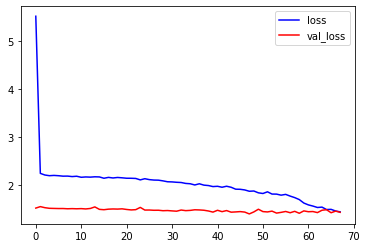

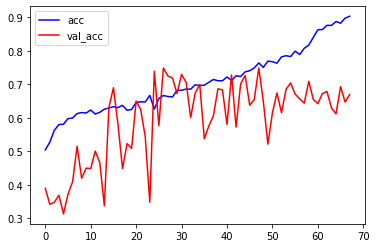


```
Predicting...
21/21 [==============================] - 73s 3s/step

Confusion matrix:
[[280 364]
 [158 494]]

Evaluating...
21/21 [==============================] - 67s 3s/step - loss: 1.4960 - accuracy: 0.5972

Per class accuracy:
0: 0.43478260869565216
1: 0.7576687116564417
Average class accuracy: 0.596225660176047
F1 score: [0.51756007 0.65430464]. Avg F1: 0.5859323548493713
```